In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import List, Tuple
%matplotlib inline

In [17]:
words = open("names.txt").read().splitlines()

In [18]:
len(words)

32033

In [19]:
chars = sorted(list(set(''.join(words))))
vocab_size = len(chars) + 1
# encoding and decoding chars
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

In [20]:
# hyperparameters
learning_rate = 0.01
max_epochs = 200000
batch_size = 32
num_embeddings = 10 # aka C
block_size = 3

In [21]:
# build dataset
def build_dataset (words: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)

# make training, validation and test splits
n1, n2 = int(len(words) * 0.8), int(len(words) * 0.9)
X_train, Y_train = build_dataset(words[:n1])
X_valid, Y_valid = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [22]:
# first layer
g = torch.Generator().manual_seed(42)
token_embedding_table = torch.randn(vocab_size, num_embeddings, generator=g)
W1 = torch.randn(num_embeddings * block_size, 200, generator=g)
b1 = torch.randn(200, generator=g)

# output layer
W2 = torch.randn(200, vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [token_embedding_table, W1, b1, W2, b2]

In [23]:
for param in parameters:
    param.requires_grad_()

In [24]:
stepi = []
lossi = []

In [25]:
for i in range(max_epochs):
    # construct minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    # forward pass
    tok_emb = token_embedding_table[X_train[ix]] # T x block_size x C
    h = torch.tanh(tok_emb.view(-1, block_size * num_embeddings) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix]) 
    
    if i % 1000 == 0:
        print(f'Loss: {loss:.4f}')

    # backward pass
    for p in parameters: # zero out the gradients
        p.grad = None
    loss.backward()

    # update parameters
    lr = learning_rate if i < max_epochs / 2 else learning_rate / 10
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())


Loss: 26.3165
Loss: 9.3758
Loss: 6.8580
Loss: 6.4169
Loss: 4.2250
Loss: 4.5964
Loss: 4.9362
Loss: 4.5753
Loss: 4.2983
Loss: 3.4320
Loss: 3.1071
Loss: 3.4025
Loss: 2.8679
Loss: 3.7253
Loss: 2.4611
Loss: 2.7106
Loss: 3.0435
Loss: 3.0834
Loss: 3.0965
Loss: 2.3104
Loss: 2.4547
Loss: 2.4511
Loss: 2.9442
Loss: 2.7080
Loss: 2.4286
Loss: 2.1168
Loss: 2.3730
Loss: 2.6207
Loss: 2.4386
Loss: 2.6644
Loss: 2.2706
Loss: 2.2782
Loss: 2.4077
Loss: 2.5017
Loss: 2.2876
Loss: 2.5163
Loss: 2.3738
Loss: 2.1374
Loss: 2.6297
Loss: 2.9261
Loss: 2.5992
Loss: 2.0202
Loss: 2.2398
Loss: 2.8484
Loss: 2.0231
Loss: 2.2947
Loss: 2.6961
Loss: 1.8534
Loss: 2.1027
Loss: 2.6759
Loss: 2.7865
Loss: 2.4343
Loss: 2.8738
Loss: 1.9756
Loss: 2.2811
Loss: 2.5306
Loss: 2.3228
Loss: 2.2493
Loss: 2.3726
Loss: 2.4795
Loss: 2.4368
Loss: 2.3221
Loss: 2.0496
Loss: 2.1380
Loss: 2.2662
Loss: 2.4214
Loss: 2.4009
Loss: 2.6989
Loss: 2.5175
Loss: 2.2565
Loss: 2.1212
Loss: 2.2490
Loss: 2.7245
Loss: 2.2607
Loss: 2.3481
Loss: 2.1443
Loss: 2.437

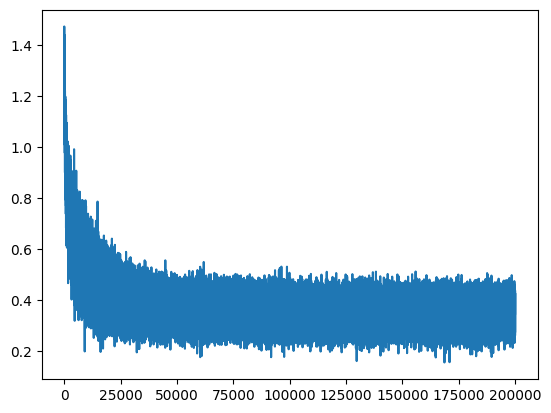

In [26]:
plt.plot(stepi, lossi)

In [27]:
# evaluate on loss on training set
tok_emb = token_embedding_table[X_train] # T x block_size x C
h = torch.tanh(tok_emb.view(-1, num_embeddings * block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train) 
loss.item()

2.2642199993133545

In [28]:
# evaluate on loss on validation set
tok_emb = token_embedding_table[X_valid] # T x block_size x C
h = torch.tanh(tok_emb.view(-1, num_embeddings * block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_valid)
loss.item()

2.27232027053833

In [29]:
# evaluate on loss on test set
tok_emb = token_embedding_table[X_test] # T x block_size x C
h = torch.tanh(tok_emb.view(-1, num_embeddings * block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
loss.item()

2.2646725177764893

In [31]:
# generate some names
g = torch.Generator().manual_seed(42)
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        tok_emb = token_embedding_table[torch.tensor([context])]
        h = torch.tanh(tok_emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix) 
        if itos[ix] == '.':
            break
    print(''.join(itos[i] for i in out))

anuhumavi.
sema.
idussan.
shan.
silaylen.
kemah.
lakan.
eaichanden.
diza.
ken.
maj.
ryri.
kalla.
mikhlynna.
cvahia.
acen.
kaitharcephelia.
sotal.
selah.
soghariah.
